# ROF and TV-L1 denoising with Primal-Dual algorithm

From http://znah.net/rof-and-tv-l1-denoising-with-primal-dual-algorithm.html

This notebook shows how ROF and TV-L1 variational denoising models can be implemented using Primal-Dual optimization alghorithm. While the denoising results may be inferior comparing to some other methods, it is still a nice toy example, showing how convex variational methods can be appied to image processing problems.

The in-depth discussion and justification of described approaches can be found in:

> *A. Chambolle et al* "An introduction to Total Variation for Image Analysis" 
> ([PDF](http://hal.archives-ouvertes.fr/docs/00/43/75/81/PDF/preprint.pdf))

Also take a look at [GPU4Vision](http://gpu4vision.icg.tugraz.at/) project for more information on variational methods in computer vision.

*Disclaimer: this notebook was written to familiarize myself with Total-Variation based methods and as a trial for IPyhon Notebook based publishing*.

In [1]:
# imports and notebook setup
#from nbutils import showarray/
import numpy as np

Let's take some image and spoil it with noise

In [2]:
import PIL.Image
from cStringIO import StringIO
import IPython.display
import numpy as np
def showarray(a, fmt='png'):
    a = np.uint8(a*255)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

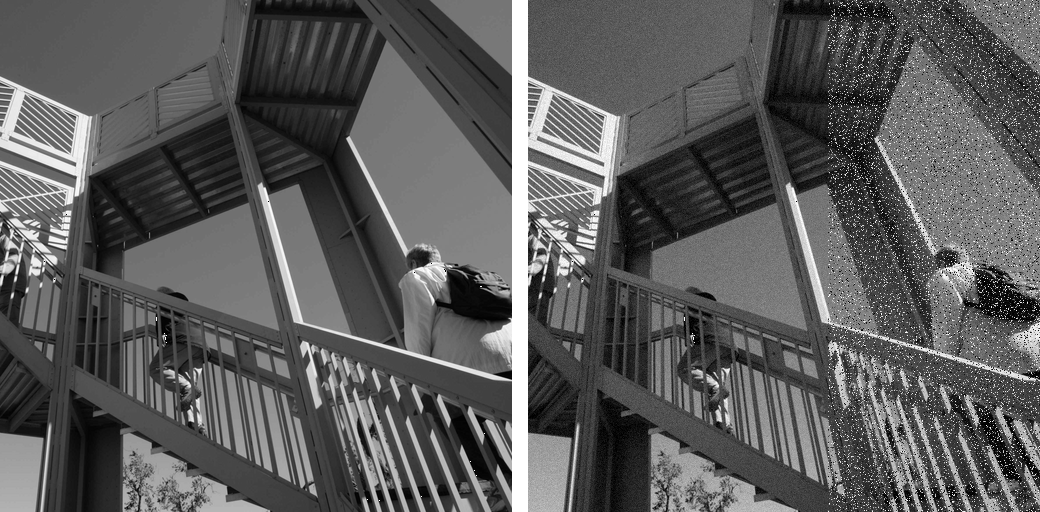

In [3]:
from scipy.misc import face, ascent
img_ref = ascent()/255. #[200:,200:][:256,:256]/255.
#img_ref = np.mean(img_ref, axis=-1)

def make_noisy(img):
    # add gaussian #noise
    img = np.clip(img + 0.025 * np.random.normal(size=img.shape), 0, 1)
    # add some outliers in on the right side of the image
    m = np.random.rand(*img.shape) < 0.2
    m[:,:300] = 0
    img[m] = np.random.rand(m.sum())
    return img

img_obs = make_noisy(img_ref)
showarray(np.hstack([img_ref, np.ones((512,16)), img_obs]))

In [4]:
ascent().shape

(512, 512)

In [5]:
? np.clip

We will compare following denoising models:
    
* ROF

$$ \min_x \|\nabla x\| + \frac{\lambda}{2} \|x - f\|^2 $$

* TV-L1

$$ \min_x \|\nabla x\| + \lambda \|x - f\| $$

where $x$ is the denoised image, $f$ is the observed image and $\lambda$ is the regularisation coefficient.

Let's define descrete $\nabla$ operator and it's transposition $\nabla^T$, which will be needed later:

In [6]:
def nabla(I):
    h, w = I.shape
    G = np.zeros((h, w, 2), I.dtype)
    G[:, :-1, 0] -= I[:, :-1]
    G[:, :-1, 0] += I[:, 1:]
    G[:-1, :, 1] -= I[:-1]
    G[:-1, :, 1] += I[1:]
    return G

def nablaT(G):
    h, w = G.shape[:2]
    I = np.zeros((h, w), G.dtype)
    # note that we just reversed left and right sides
    # of each line to obtain the transposed operator
    I[:, :-1] -= G[:, :-1, 0]
    I[:, 1: ] += G[:, :-1, 0]
    I[:-1]    -= G[:-1, :, 1]
    I[1: ]    += G[:-1, :, 1]
    return I

Now we can define functions for computing current solution's energy:

In [7]:
# little auxiliary routine
def anorm(x):
    '''Calculate L2 norm over the last array dimention'''
    return np.sqrt((x*x).sum(-1))

def calc_energy_ROF(X, observation, clambda):
    Ereg = anorm(nabla(X)).sum()
    Edata = 0.5 * clambda * ((X - observation)**2).sum()
    return Ereg + Edata

def calc_energy_TVL1(X, observation, clambda):
    Ereg = anorm(nabla(X)).sum()
    Edata = clambda * np.abs(X - observation).sum()
    return Ereg + Edata

# some reasonable lambdas
lambda_ROF = 8.0
lambda_TVL1 = 1.0

print "ROF:",
print calc_energy_ROF(img_obs, img_obs, lambda_ROF), 
print calc_energy_ROF(img_ref, img_obs, lambda_ROF)
print "TV-L1:",
print calc_energy_TVL1(img_obs, img_obs, lambda_TVL1), 
print calc_energy_TVL1(img_ref, img_obs, lambda_TVL1)


ROF: 36315.5743691 24924.127949
TV-L1: 36315.5743691 23309.0418266


OK, at least we see that noisy image energy is greater than the reference.

Saddle point formulation
------------------------

Now we can apply the Primal-Dual algorithm to minimize defined energy. Algorithm works on a general problems, defined in a form 

$$ \min_x \; F(Kx) + G(x) \tag{1} $$

where $F$ and $G$ are some convex functions and $K$ is a linear operator. First we define the dual of a function: 
    
$$ F^*(p) = \sup_ {x \in X} \; \langle p, x \rangle - F(x) \tag{2} $$

It can be shown that for convex functions

$$ F = F^{**}(p) = \sup_ {x \in X} \; \langle p, x \rangle - F^*(x)$$

Applying this transormation to function $F$ in (1) we get the following saddle point problem:

$$ \min_x \; \max_p  \; \langle Kx, p\rangle  + G(x) - F^*(p)
\tag{3}
$$

In both ROF and TV-L1 denoising modelds regularisation term $F(Kx) = \sum_i \| \nabla x_i \|$, where $\nabla x_i$ is a two-dimentional intensity gradient vector at image pixel $i$. Then, according to (2)

$$ F^*(p) = \delta_P(p) = 
\begin{cases}
0       & p \in P \\
+\infty & p \notin P
\end{cases}
$$

where $P = \{p :  \forall i \; \| p_i \| \leq 1\}$

Proximity operator
------------------

Before proceding to the Primal-Dual algoritm we have to define the *proximity operator* of a function:
    
$$ (I + \tau \partial F)^{-1}(x) =  argmin_{y} \frac{1}{2}\|y-x\|^2 + \tau F(y) $$

This operator is equivalent to implicit gradient descent step for a function. In order to use Primal-Dual algorithm, functions $F^*$ and $G$ must have an easy to compute proximity operator. For example:
    
$$
\begin{eqnarray} 
F^*(p) =  \delta_P(p) \quad &\Leftrightarrow & \quad
(I + \sigma \partial F^*)^{-1}(p) &= \mathbf{project}_P (p) \\
G_{ROF}(x) = \frac{\lambda}{2} \|x - f\|^2 \quad &\Leftrightarrow & \quad
(I + \tau \partial G_{ROF})^{-1}(x) &= \frac{x + \lambda\tau f}{1 + \lambda\tau} \\
G_{TV-L1}(x) =  \lambda \|x - f\| \quad &\Leftrightarrow & \quad
(I + \tau \partial G_{TV-L1})^{-1}(x) &= \mathbf{shrink} (x, f, \lambda\tau)
\end{eqnarray}
$$

Where 

$$\mathbf{project}_P(p) = \frac{p}{max(\|p\|, 1)}$$ 

is a pixel-wise euclidian projection onto feasible set $P$ and 

$$ \mathbf{shrink} (x, f, \lambda\sigma) = 
\begin{cases}
x - \lambda\sigma & x > f + \lambda\sigma \\
x + \lambda\sigma & x < f - \lambda\sigma \\
f & |x-f| \leq \lambda\sigma
\end{cases}$$

Here are the implementations of the auxiliary functions $\mathbf{project}$ and $\mathbf{shrink}$:  

In [8]:
def project_nd(P, r):
    '''perform a pixel-wise projection onto R-radius balls'''
    nP = np.maximum(1.0, anorm(P)/r)
    return P / nP[...,np.newaxis]
    
def shrink_1d(X, F, step):
    '''pixel-wise scalar srinking'''
    return X + np.clip(F - X, -step, step)

Primal-Dual algorithm
---------------------

Now we are ready to implement the Primal-Dual algorithm. Here it is in it's general form:

* Choose step sizes $\sigma > 0$ and $\tau > 0$, so that $\sigma\tau L^2 < 1$, where $L = \|K\|$, and set $\theta = 1.$
* Choose some initial values for pimal variable $x_0$ and dual variable $p_0$. Our model is convex,  so any assignment should converge to the global minima.
* Iterate until convergence:
$$
\begin{cases}
p_{n+1} = (I + \sigma\partial F^*)^{-1} (p_n + \sigma K x_n) \\
\hat x_{n+1} = (I + \tau\partial   G)^{-1} (x_n - \tau K^T p_{n+1}) \\
x_{n+1} = \hat x_{n+1} + \theta (\hat x_{n+1} - x_n)
%\frac {\|x\|} {2\alpha} & \|x\| \le \alpha \\
%\|x\| - \frac {\alpha} {2} & \|x\| > \alpha
\end{cases} 
$$

Everything is ready to write some code! We'll start with the ROF model.

25921.07 18029.87 16951.71 16803.41 16778.68 16768.86 16762.87 16758.79 16755.80 16753.55 16751.75


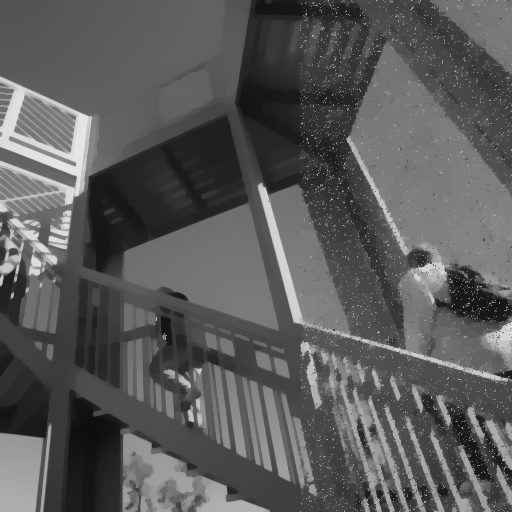

In [9]:
def solve_ROF(img, clambda, iter_n=101):
    # setting step sizes and other params
    L2 = 8.0
    tau = 0.02
    sigma = 1.0 / (L2*tau)
    theta = 1.0

    X = img.copy()
    P = nabla(X)
    for i in xrange(iter_n):
        P = project_nd( P + sigma*nabla(X), 1.0 )
        lt = clambda * tau
        X1 = (X - tau * nablaT(P) + lt * img) / (1.0 + lt)
        X = X1 + theta * (X1 - X)
        if i % 10 == 0:
            print "%.2f" % calc_energy_ROF(X, img, clambda),
    print
    return X

showarray(solve_ROF(img_obs, 8.0))

While the ROF model denoising worked reasonably well in the left part of image, where the noise is normaly distributed, outliers are still present in the right part. We may try to decrease $\lambda$ value to suppress them, but this leads to reconstructed image oversmoothing:

24652.47 14090.08 10989.61 9234.40 8187.48 7534.59 7118.41 6859.20 6695.45 6593.37 6531.48


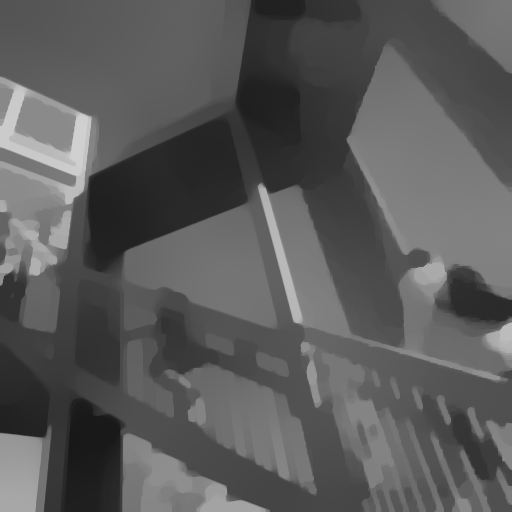

In [10]:
showarray(solve_ROF(img_obs, 2.0))

Now let's try the TV-L1 model:

31339.95 24114.64 22283.65 21273.42 20716.90 20358.84 20088.02 19890.03 19742.04 19624.72 19530.93


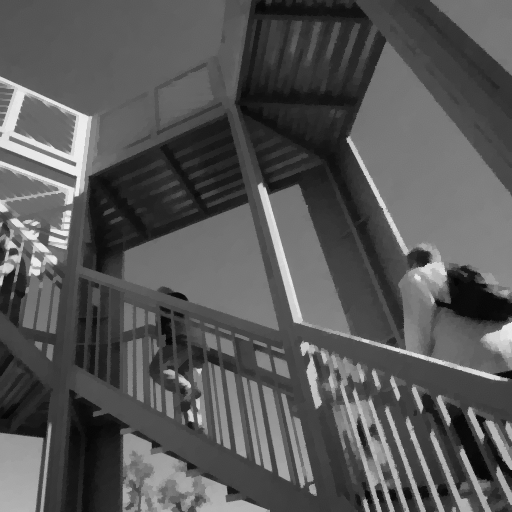

In [131]:
def solve_TVL1(img, clambda, iter_n=101):
    # setting step sizes and other para1s
    L2 = 8.0
    tau = 0.02
    sigma = 1.0 / (L2*tau)
    theta = 1.0

    X = img.copy()
    P = nabla(X)
    for i in xrange(iter_n):
        P = project_nd( P + sigma*nabla(X), 1.0 )
        X1 = shrink_1d(X - tau*nablaT(P), img, clambda*tau)
        X = X1 + theta * (X1 - X)
        if i % 10 == 0:
            print "%.2f" % calc_energy_TVL1(X, img, clambda),
    print
    return X

showarray(solve_TVL1(img_obs, 1))

Outliers are gone, while details are preserved.

Saddle-point problem formulation for multiple observations
----------------------------------------------------------

Suppose we want to reconstruct a signal from multiple noisy observations with TV-L1 model.

Let's generate some test data first.

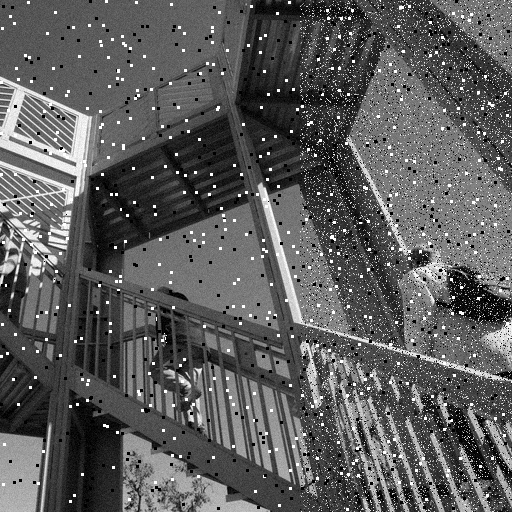

In [12]:
def make_spotty(img, r=3, n=1000):
    img = img.copy()
    h, w = img.shape
    for i in xrange(n):
        x, y = np.int32(np.random.rand(2)*(w-r, h-r))
        img[y:y+r, x:x+r] = round(np.random.rand())
    return img

observations = [make_spotty(make_noisy(img_ref)) for i in xrange(5)]
showarray(observations[0])

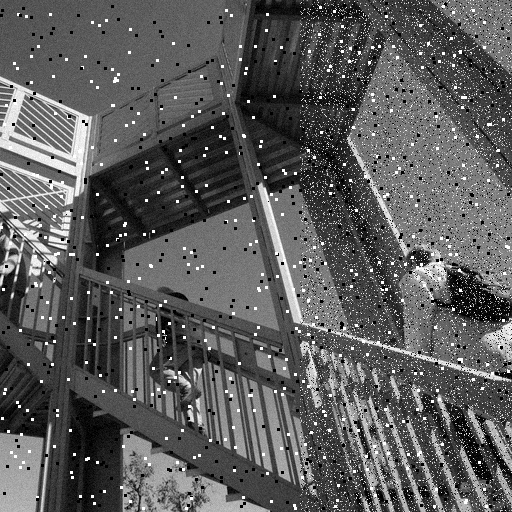

In [13]:
showarray(observations[1])

We are going to optimize the following function:

$$ \min_x \|\nabla x\| + \lambda \sum_i \|x - f_i\| $$

or, in general

$$ \min_x \; F(Kx) + \sum_i G_i(x) $$

Lets apply the dual transormation to all $F$ and $G_i$ functions, obtaining:
    
$$ \min_x \; \max_{p,r_i} \; \langle Kx, p\rangle - F^*(p) + \sum_i [ \langle x, r_i\rangle - G_i^*(r_i) ]$$

$$G_i(x) = \lambda |x-f_i| \quad \Rightarrow \quad
G_i^*(r) = rf_i + \delta_{|r| \leq \lambda}(r)
$$

Primal-Dual algorithm iteration then becomes:

$$
\begin{cases}
p_{n+1} = (I + \sigma\partial F^*)^{-1} (p_n + \sigma K x_n) \\
r^i_{n+1} = (I + \sigma\partial G_i^*)^{-1} (r^i_n + \sigma x_n) \\
\hat x_{n+1} = x_n - \tau (K^T p_{n+1} + \sum_i r^i_{n+1}) \\
x_{n+1} = \hat x_{n+1} + \theta (\hat x_{n+1} - x_n)
%\frac {\|x\|} {2\alpha} & \|x\| \le \alpha \\
%\|x\| - \frac {\alpha} {2} & \|x\| > \alpha
\end{cases} 
$$

. . . . . . . . . . .

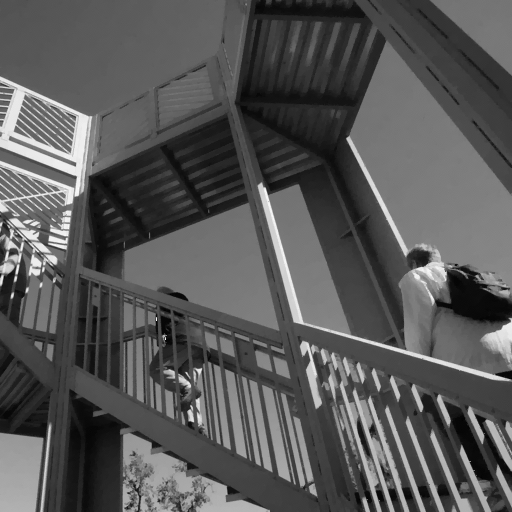

In [14]:
def solve_TVL1_multy(imgs, clambda, iter_n=101):
    # setting step sizes and other params
    L2 = 8.0
    tau = 0.02
    sigma = 1.0 / (L2*tau)
    theta = 1.0

    imgs = np.array(imgs)
    X = imgs[0].copy()
    P = nabla(X)
    Rs = np.zeros_like(imgs)
    for i in xrange(iter_n):
        P = project_nd( P + sigma*nabla(X), 1.0 )
        Rs = np.clip(Rs + sigma*(X-imgs), -clambda, clambda)
        X1 = X - tau*(nablaT(P) + Rs.sum(0))
        X = X1 + theta * (X1 - X)
        if i % 10 == 0:
            print ".",
    return X

showarray(solve_TVL1_multy(observations, 0.5))

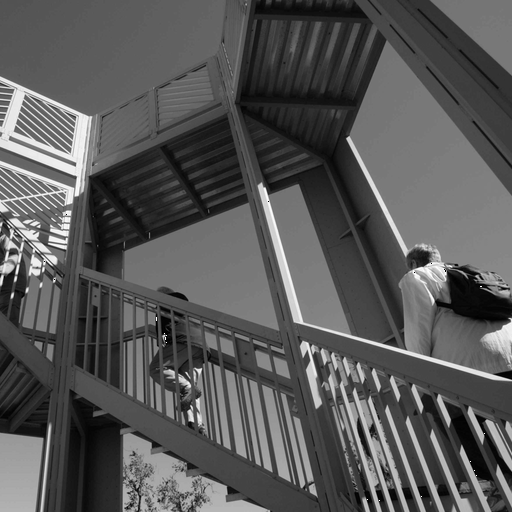

In [15]:
showarray(img_ref)

34365.92 26964.14 24825.48 23619.79 22958.85 22511.84 22216.28 22006.31 21845.29 21712.62 21612.06


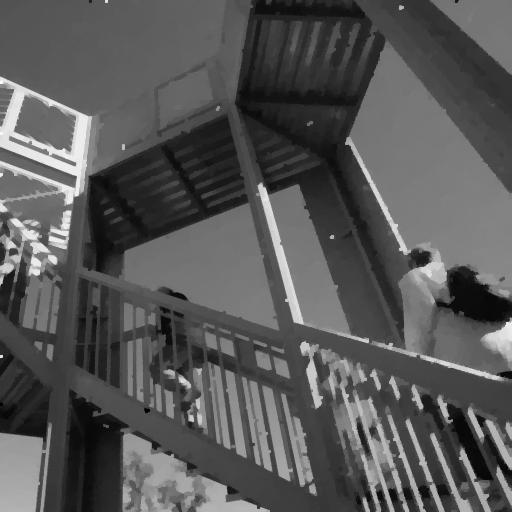

In [16]:
showarray(solve_TVL1(observations[0], 0.9))

In [17]:
def write_ppm(fname, im, xval):
     
    height, width, nc = im.shape
    assert nc == 3
     
    f = open(fname, 'w')
     
    f.write('P3\n')
    f.write(str(width)+' '+str(height)+'\n')
    f.write(str(xval)+'\n')
     
    # interleave image channels before streaming    
    c1 = np.reshape(im[:, :, 0], (width*height, 1))
    c2 = np.reshape(im[:, :, 1], (width*height, 1))
    c3 = np.reshape(im[:, :, 2], (width*height, 1))
     
    im1 = np.hstack([c1, c2, c3])
    im2 = im1.reshape(width*height*3)
 
    f.write('\n'.join(im2.astype('str')))
    f.write('\n')
 
    f.close()

In [18]:
out = np.transpose(np.array([np.uint8(img_obs*255)]*3), (1,2,0))

In [19]:
out

array([[[ 87,  87,  87],
        [103, 103, 103],
        [ 84,  84,  84],
        ..., 
        [105, 105, 105],
        [122, 122, 122],
        [116, 116, 116]],

       [[ 80,  80,  80],
        [ 74,  74,  74],
        [ 84,  84,  84],
        ..., 
        [127, 127, 127],
        [ 20,  20,  20],
        [137, 137, 137]],

       [[ 80,  80,  80],
        [ 83,  83,  83],
        [ 66,  66,  66],
        ..., 
        [113, 113, 113],
        [115, 115, 115],
        [117, 117, 117]],

       ..., 
       [[182, 182, 182],
        [179, 179, 179],
        [164, 164, 164],
        ..., 
        [100, 100, 100],
        [200, 200, 200],
        [133, 133, 133]],

       [[175, 175, 175],
        [179, 179, 179],
        [180, 180, 180],
        ..., 
        [ 54,  54,  54],
        [ 57,  57,  57],
        [ 15,  15,  15]],

       [[168, 168, 168],
        [171, 171, 171],
        [187, 187, 187],
        ..., 
        [ 55,  55,  55],
        [ 61,  61,  61],
        [ 50,  50,

In [20]:
write_ppm('img_obs', out, 255)

In [22]:
P = nabla(img_obs)

In [24]:
    L2 = 8.0
    tau = 0.02
    sigma = 1.0 / (L2*tau)
    theta = 1.0

In [29]:
shrink_1d(img_obs - tau*nablaT(project_nd(7.25*P, 1)), img_obs, 1*tau)

array([[ 0.34246834,  0.38957383,  0.32986158, ...,  0.41219231,
         0.46803885,  0.45492887],
       [ 0.31471159,  0.30324553,  0.33284439, ...,  0.4980055 ,
         0.12805387,  0.51964446],
       [ 0.31633776,  0.3271179 ,  0.27975846, ...,  0.44513969,
         0.4391686 ,  0.46254952],
       ..., 
       [ 0.71467951,  0.70337358,  0.65531202, ...,  0.38811655,
         0.74096635,  0.51317603],
       [ 0.68822121,  0.70466263,  0.70782955, ...,  0.21343336,
         0.22546779,  0.10008457],
       [ 0.66225214,  0.6737024 ,  0.73613848, ...,  0.2162397 ,
         0.23992151,  0.19690296]])

In [30]:
img_obs

array([[ 0.34246834,  0.40641922,  0.32986158, ...,  0.41219231,
         0.47886979,  0.45492887],
       [ 0.31471159,  0.29282156,  0.33284439, ...,  0.50001302,
         0.08012529,  0.53822054],
       [ 0.31633776,  0.32713153,  0.25919861, ...,  0.44513969,
         0.4520741 ,  0.46254952],
       ..., 
       [ 0.71467951,  0.70337358,  0.64461265, ...,  0.3943292 ,
         0.78569414,  0.52473097],
       [ 0.68822121,  0.70466263,  0.70782955, ...,  0.21343336,
         0.22546779,  0.06036238],
       [ 0.66225214,  0.6737024 ,  0.73613848, ...,  0.2162397 ,
         0.23992151,  0.19690296]])

In [34]:
solve_TVL1(img_obs, 1).min()

31339.95 24114.64 22283.65 21273.42 20716.90 20358.84 20088.02 19890.03 19742.04 19624.72 19530.93


0.022048484662509547

In [35]:
uo = np.fromfile('ESB_s119.75Hz_c4.00Hz_100ms_2016-05-24-215440-0320.raw', dtype=np.uint8)

In [46]:
uo = uo.reshape(1530, 2444, 3)

In [47]:
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


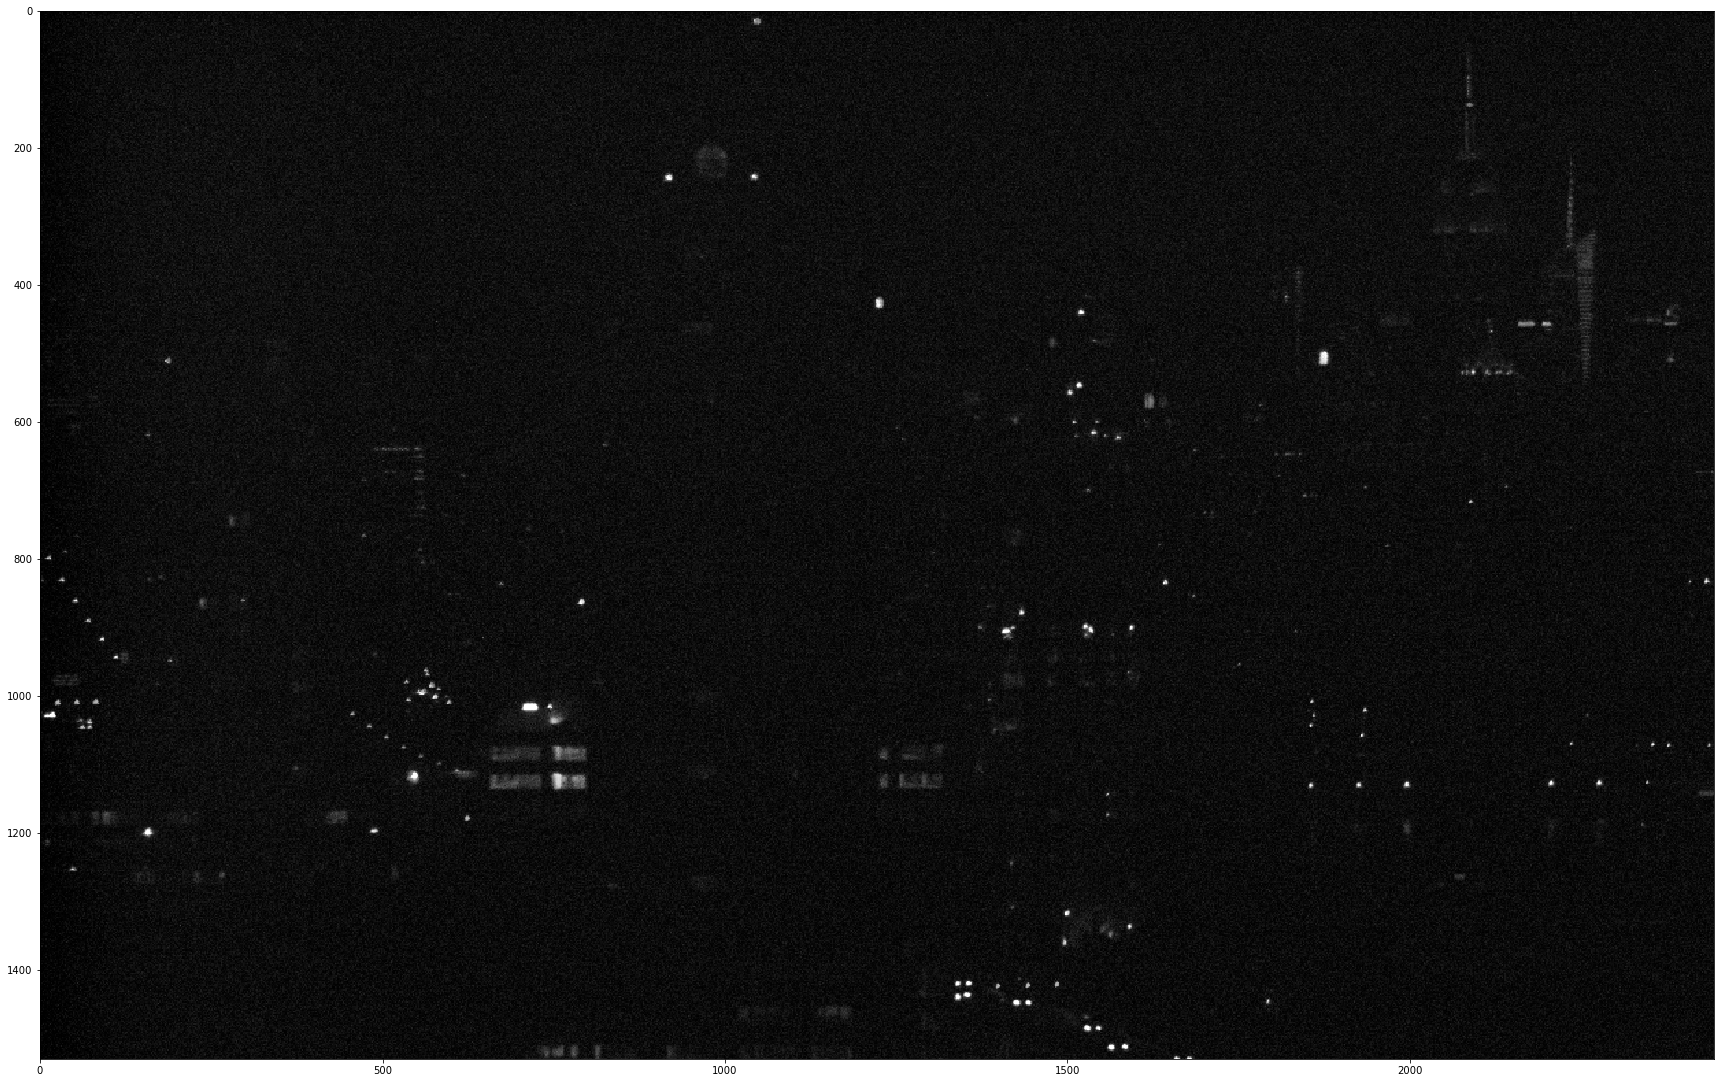

In [116]:
pl.figure(figsize=(30,20))
uo_gr = uo.mean(-1)
pl.imshow(uo_gr, cmap='gray')

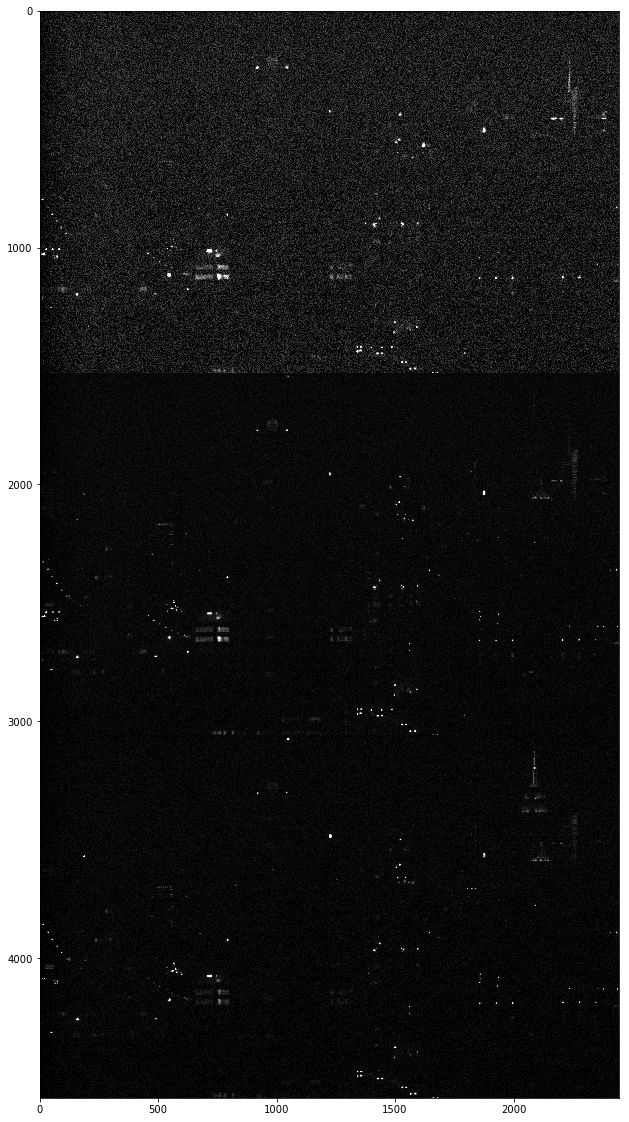

In [113]:
pl.figure(figsize=(30,20))
pl.imshow(np.vstack([uo[:,:,i] for i in xrange(3)]), cmap='gray')

In [114]:
sol = solve_TVL1(uo.mean(-1), 0.005, 101)

28706617.96 25362948.62 22832214.32 20690151.98 18767664.90 17000227.42 15364833.47 13850224.17 12451203.39 11163147.91 9980678.12


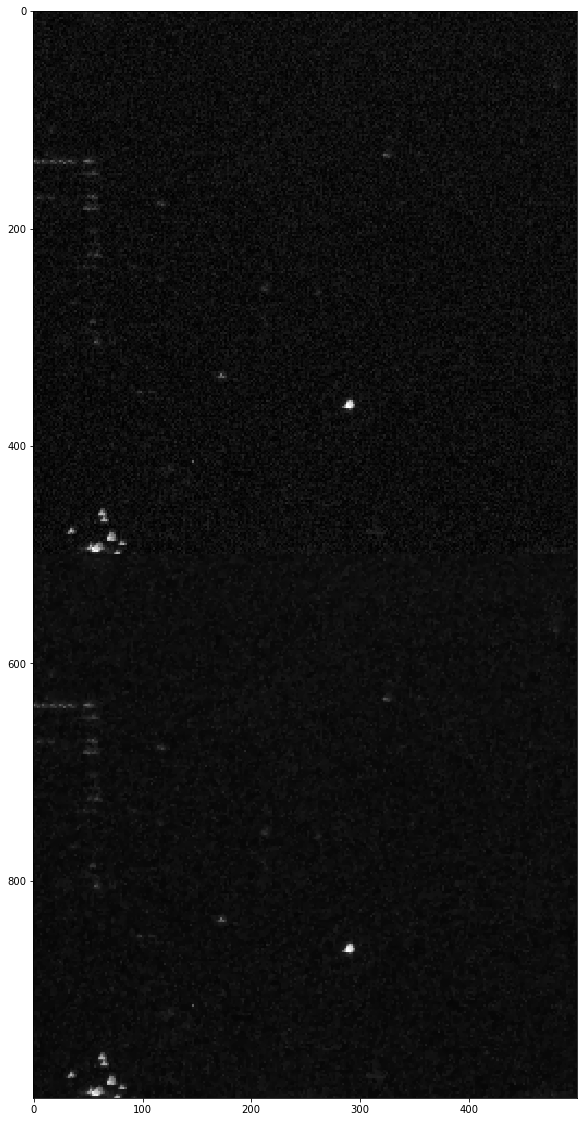

In [129]:
pl.figure(figsize=(30,20))
pl.imshow(np.vstack([uo_gr[500:1000,500:1000],sol[500:1000,500:1000]]), cmap='gray')

/home/cmp/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


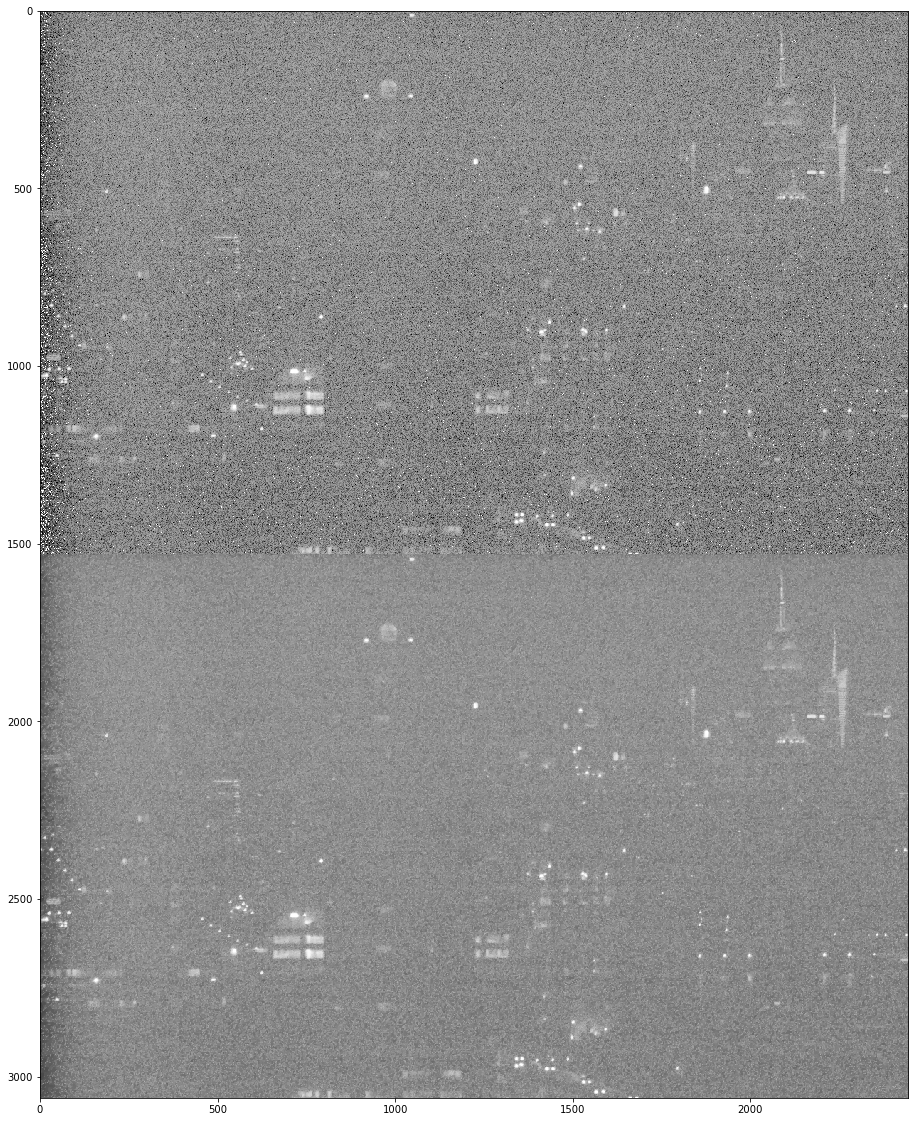

In [123]:
pl.figure(figsize=(30,20))
pl.imshow(np.log(np.vstack([uo_gr,sol])), cmap='gray')

In [133]:
write_ppm("uo.ppm", np.transpose(np.array([np.uint8(uo_gr)]*3), (1,2,0)), 255)